In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv')[:16]
df

,fen_value,score
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-33
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,34
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,-30
3,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,30
4,r1bqkbnr/pppp1ppp/2n5/4p3/2B1P3/5N2/PPPP1PPP/R...,-29
5,r1bqk1nr/pppp1ppp/2n5/2b1p3/2B1P3/5N2/PPPP1PPP...,80
6,r1bqk1nr/pppp1ppp/2n5/2b1p3/2B1P3/2P2N2/PP1P1P...,-48
7,r1bqk1nr/1ppp1ppp/p1n5/2b1p3/2B1P3/2P2N2/PP1P1...,130
8,r1bqk1nr/1ppp1ppp/p1n5/2b1p3/2BPP3/2P2N2/PP3PP...,-103
9,r1bqk1nr/1ppp1ppp/p1n5/2b5/2BpP3/2P2N2/PP3PPP/...,156


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)
X

tensor([[ 9, 11, 10,  ...,  1,  1,  0],
        [ 9, 11, 10,  ...,  1,  1,  0],
        [ 9, 11, 10,  ...,  1,  1,  0],
        ...,
        [ 9,  0, 10,  ...,  1,  1,  0],
        [ 9,  0, 10,  ...,  1,  1,  0],
        [ 9,  0, 10,  ...,  1,  1,  0]], dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings)
y

tensor([-0.0033,  0.0034, -0.0030,  0.0030, -0.0029,  0.0080, -0.0048,  0.0130,
        -0.0103,  0.0156, -0.0102,  0.0204, -0.0218,  0.0200,  0.0021, -0.0014])

# Helper Functions

In [7]:
def get_batch(X, Y, bs):
    if bs > len(X): bs = len(X)
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch]
    y = Y[batch]
    return x, y
# b = get_batch(X, y, 64)

# Training

In [8]:
# hyperparameters
lr = 0.001
num_steps = 100
bs = 16
# allowed_error = 100 # 

In [9]:
model = MLPEngine(embedding_dim=32)
loss_category = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = lr)
model.compile()

In [10]:
history = []
for epoch in range(num_steps):
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    history.append(loss.item())
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()



In [11]:
history

[0.0004992109606973827,
 0.00017348030814900994,
 0.00020684950868599117,
 0.00014097131497692317,
 0.00017565513553563505,
 8.104245353024453e-05,
 0.00020057946676388383,
 0.0001327177888015285,
 9.538533049635589e-05,
 0.00014505087165161967,
 0.00015352694026660174,
 9.149080142378807e-05,
 8.46725597511977e-05,
 0.00014665555499959737,
 0.00011949577310588211,
 0.00013601031969301403,
 0.00013322412269189954,
 0.00017562200082466006,
 0.00014605108299292624,
 6.931448297109455e-05,
 0.00012203253572806716,
 0.0001749681105138734,
 0.00010420583566883579,
 0.00010524668323341757,
 0.00014176273543853313,
 0.00013443062198348343,
 0.00013302909792400897,
 0.000166986501426436,
 4.98230911034625e-05,
 0.00010155405470868573,
 0.00011047209409298375,
 8.576527761761099e-05,
 0.00016528555715922266,
 0.00013916281750425696,
 9.636802860768512e-05,
 0.0001334767002845183,
 0.00010598181688692421,
 0.00011643327889032662,
 0.00017130051855929196,
 0.0001197739620693028,
 5.51697849004995

/home/arjun/Desktop/AI_ENV/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/arjun/Desktop/AI_ENV/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


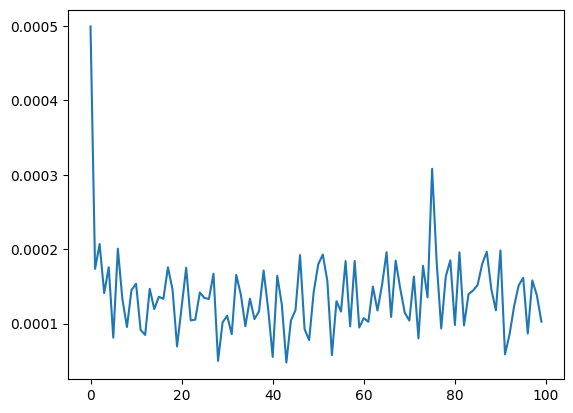

In [12]:
plt.plot(history)